#<font color='teal'> Fatal Encounters </font>

#### Fatal Encounters is a database of people who have died in connection with an off-duty or working police officer(s). It contains deaths from 2000 to present day and as of 2020, has approximately 30K entries with names, dates, locations of the deceased as well as race, gender, age, location and the policing agency associated with the death. The notebook explores some of the trends in gender, cause, and the locality of these fatalities. The dataset is available here: https://docs.google.com/spreadsheets/d/1dKmaV_JiWcG8XBoRgP8b4e9Eopkpgt7FL7nyspvzAsE/edit#gid=0
and it must be loaded as a csv file onto your google drive for this notebook to compile correctly.

In [ ]:
#load python packages
import os
import io
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
!pip install geopy
import folium
!pip install geopandas
import geopandas as gpd
!pip install contextily
import contextily as ctx
from geopy.geocoders import Nominatim
import datetime as dt
%matplotlib inline
!pip install pygal
!pip install cairosvg
from IPython.core.display import display, HTML
import cairosvg
import pygal 
from pygal.style import Style
#import data into google drive, mount google drive and load data
#####import data into google drive if not already there####
from google.colab import files 
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
from google.colab import drive
###########mount google drive########
drive.mount('/content/drive')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##<font color='teal'> Data Loading, cleanup and filling in missing data </font>

In [ ]:
###########Load the data##############
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
os.chdir('/content/drive/My Drive/Colab Notebooks/data')
df = pd.read_csv('FatalEncounters9-17-20.csv', engine='python')

df.drop(df.tail(1).index,inplace=True) #Remove the last row, which is a spacer
#####Rename the columns to make them easier to query#####
df=df.rename(columns={'Subject\'s name': 'Name','Unique ID':'ID','Subject\'s age':'Age','Subject\'s gender':'Gender','Subject\'s race':'Race',
                      'Subject\'s race with imputations':'Imputed_race','Imputation probability':'Imputation_prob','URL of image of deceased':'URL_image',
                      'Date of injury resulting in death (month/day/year)':'Injury_date','Location of injury (address)':'Injury_loc','Location of death (state)':'Death_loc_st',
                      'Location of death (zip code)':'Death_loc_zip','Location of death (county)':'Death_loc_county','Full Address':'Address',
                      'Agency responsible for death':'Resp_Ag','Cause of death':'Cause','A brief description of the circumstances surrounding the death':'Descrip',
                      'Dispositions/Exclusions INTERNAL USE, NOT FOR ANALYSIS':'NFA_Cause','Intentional Use of Force (Developing)':'Int_force',
                      'Link to news article or photo of official document':'link','Symptoms of mental illness? INTERNAL USE, NOT FOR ANALYSIS':'Mental_ill',
                      'Unique identifier (redundant)':'ID','Date (Year)':'Year','Location of death (city)':'Death_loc_city'})
#####Drop columns with repeated information#######
df.drop(columns=['Unique ID formula','Date&Description'], inplace=True)
#####Fill in missing zip codes, counties and cities using Nominatim and supplied lat/long data values#######
geolocator = Nominatim(timeout=10, user_agent = "Springboard")
for index, row in df.iterrows(): 
  if pd.isnull(row.Death_loc_zip): #if there is a null value in zip code
    x = str(row.Latitude) + str(" ") + str(row.Longitude)
    location = geolocator.geocode(x,addressdetails=True) #look it up in geopy
    key='postcode'
    if key in location.raw['address']: #some of the lat longs don't have a zip code (like neighborhoods)
      df.loc[index,'Death_loc_zip'] = location.raw['address']['postcode']
    #print(df.loc[index,'Death_loc_zip'])
  if pd.isnull(row.Death_loc_city): #if there is a null value in city
    x = str(row.Latitude) + str(" ") + str(row.Longitude)
    location = geolocator.geocode(x,addressdetails=True) #look it up in geopy
    key='city'
    if key in location.raw['address']: #some of the lat longs are unincorporated
      df.loc[index,'Death_loc_city'] = location.raw['address']['city']
    #print(df.loc[index,'Death_loc_city'])
  if pd.isnull(row.Death_loc_county): #if there is a null value in county
    x = str(row.Latitude) + str(" ") + str(row.Longitude)
    location = geolocator.geocode(x,addressdetails=True) #look it up in geopy
    key='county'
    if key in location.raw['address']: #to account for no county information
      df.loc[index,'Death_loc_county'] = location.raw['address']['county']
    #print(df.loc[index,'Death_loc_county'])
#####Fill in missing year values using Injury date#######
  if pd.isnull(row.Year):
      df.loc[index,'Year'] = pd.DatetimeIndex(row.Injury_date).year 
#####Fill in missing cities using Injury location#######
  if pd.isnull(row.Injury_loc): #if there is a null value in injury location
      df.loc[index,'Injury_loc'] = row.Death_loc_city
      #print(df.loc[index,'Injury_loc'])
#####Fill in missing gender using descriptions in deaths caused by gunshot#######
  if pd.isnull(row.Gender):
      if row.Cause == 'Gunshot':
        s = row.Descrip
        if 'man' in s:
          #print(row.Cause, row.ID, row.Descrip)
          df.loc[index,'Gender'] = 'Male'
        if 'woman' in s:
          #print(row.Cause, row.ID, row.Descrip)
          df.loc[index,'Gender'] = 'Female'
#####Replace non-numeric values in Age with numeric estimates###########
temp=df.Age.fillna("0")
temp2 = np.where(temp.str.contains("months"))
for i in temp2:
  df.loc[i,'Age']= pd.to_numeric(temp[i].str.strip('months'))/12
  dict = {'20s':'25','30s':'35','40s':'45','50s':'55','60s':'65','70s':'75','20s-30s':'30','18-25':'21.5','40-50':'45','3 days':3/365,'46/53':np.nan} #Values to re-map
df.replace({"Age": dict}, inplace=True)
df['Age']=pd.to_numeric(df.Age)
#####Fill in any remaining missing values with Nans###############
df.fillna(np.nan, inplace=True) 

#<font color='teal'> Initial results</font>

Results show a large number of deaths occuring at 2347 S. Michigan Avenue in Chicago occurring on Feb. 19, 2003, which upon further investigation, appears to have been related to a single stampede in a night club caused by a police officer using pepper spray inside the building. There was also a large number of deaths occuring on June 25, 2020, related to a vehicle crash after fleeing a border control check, and large number on March 28, 2014 related to a reckless driving incident. The missing values for Age were not imputed from a mean to avoid putting abnormal values in its distribution.

#<font color='teal'> Age of fatal encounters </font>
The most common age to be killed is 22, with an average age of 35 years old. The youngest person was 3 days old, and was killed after an emergency delivery following a vehicle crash which killed his mother, a passenger in the car. The oldest was 107, who died when police returned fire at a residence.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

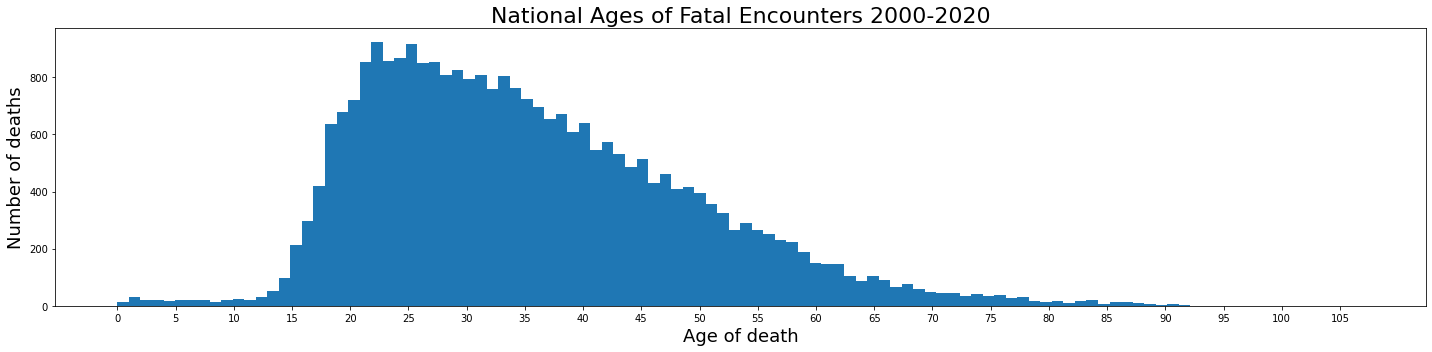

In [ ]:
Ageplot=plt.figure(figsize=(20,5))
plt.hist(df.Age.astype('float'),bins=108) #there are 108 unique values
plt.xlabel('Age of death', fontsize=18)
plt.ylabel('Number of deaths', fontsize=18)
plt.title('National Ages of Fatal Encounters 2000-2020', fontsize=22)
sns.set_style("whitegrid")
plt.xticks(range(0,110,5))
plt.tight_layout()
Ageplot.show()
from google.colab import files
Ageplot.savefig("Age.jpg")
files.download("Age.jpg") 

#<font color='teal'> Gender of fatal encounters </font>
Deaths are by far mostly male in comparison to females or transgender individuals.

In [ ]:
custom_style = Style(
    legend_font_size = 4,
    title_font_size = 5,
    value_font_size=4)
Genderplot = pygal.Pie(width=200, height=200, style=custom_style, legend_box_size=2
                              , title='Genders of Fatal Encounters', print_values=True)
genders=['Male','Female','Transgender']
values = df.Gender.value_counts()

for row in range(0,3):
    sex = genders[row]
    num = values[genders[row]]
    Genderplot.add(sex,num)  
Genderplot.value_formatter = lambda x: "{:.0f}".format(x)
Genderplot.render() 
no_wrap_div = '<div style="white-space: nowrap; overflow-x: auto">{}{}</div>' 
html_pygal = u"""
    <!DOCTYPE html>
    <html>
        <head>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
        </head>
        <body><figure>{pygal_render}</figure></body>
    </html>
"""
HTML(html_pygal.format(pygal_render=Genderplot.render(is_unicode=True)))
#from google.colab import files
#Genderplot.render_to_png('Gender.png')
#files.download("Gender.png") 

#<font color='teal'> Cause of fatal encounters for males </font>
For males, the most common cause of death is by gunshot.

In [ ]:
custom_style = Style(
    legend_font_size = 2,
    title_font_size = 5,
    value_font_size=4)
MaleCODPlot = pygal.Pie(width=200, height=200, style=custom_style, legend_box_size=10
                              , title='Male Cause of Fatal Encounter', print_values=True, truncate_legend=50)
causes=['Gunshot','Vehicle','Tasered','Medical emergency','Asphyxiated/Restrained','Beaten/Bludgeoned with instrument','Drowned','Drug overdose','Other']
values = df.loc[df['Gender'] == 'Male'].Cause.value_counts()[:8]
other = np.sum(df.loc[df['Gender'] == 'Male'].Cause.isin(['Undetermined','Fall from a height','Chemical agent/Pepper Spray',
                                                                 'Burned/Smoke inhalation','Stabbed','Unknown']))
values.at['Other'] = other

for row in range(0,9):
    cause = causes[row]
    num = values[causes[row]]
    MaleCODPlot.add(cause,num)  
MaleCODPlot.value_formatter = lambda x: "{:.0f}".format(x)
MaleCODPlot.render() 
no_wrap_div = '<div style="white-space: nowrap; overflow-x: auto">{}{}</div>' 
html_pygal = u"""
    <!DOCTYPE html>
    <html>
        <head>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
        </head>
        <body><figure>{pygal_render}</figure></body>
    </html>
"""
HTML(html_pygal.format(pygal_render=MaleCODPlot.render(is_unicode=True)))
#from google.colab import files
#MaleCODPlot.render_to_png('MaleCOD.png')
#files.download("MaleCOD.png") 

#<font color='teal'> Cause of fatal encounters for females </font>
For females, the most common cause of death is by means of a vehicle.

In [ ]:
custom_style = Style(
    legend_font_size = 2,
    title_font_size = 5,
    value_font_size=4)
FemaleCODPlot = pygal.Pie(width=200, height=200, style=custom_style, legend_box_size=10
                              , title='Female Causes of Fatal Encounters', print_values=True, truncate_legend=50)
causes=['Vehicle','Gunshot','Medical emergency','Drug overdose','Tasered','Drowned','Stabbed','Asphyxiated/Restrained']
values = df.loc[df['Gender'] == 'Female'].Cause.value_counts()
other = np.sum(df.loc[df['Gender'] == 'Female'].Cause.isin(['Undetermined','Beaten/Bludgeoned with instrument','Fell from a height','Chemical agent/Pepper Spray',
                                                                 'Burned/Smoke inhalation','Stabbed','Undetermined','Pursuit','Other']))
values.at['Other'] = other

for row in range(0,8):
    cause = causes[row]
    num = values[causes[row]]
    FemaleCODPlot.add(cause,num)  
FemaleCODPlot.value_formatter = lambda x: "{:.0f}".format(x)
FemaleCODPlot.render() 
no_wrap_div = '<div style="white-space: nowrap; overflow-x: auto">{}{}</div>' 
html_pygal = u"""
    <!DOCTYPE html>
    <html>
        <head>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
        </head>
        <body><figure>{pygal_render}</figure></body>
    </html>
"""
HTML(html_pygal.format(pygal_render=FemaleCODPlot.render(is_unicode=True)))
#from google.colab import files
#FemaleCODPlot.render_to_png('FemaleCOD.png')
#files.download("FemaleCOD.png") 

#<font color='teal'> Cause of fatal encounters for Transgender individuals </font>
For transgender individuals, the most common cause of death is by gunshot.

In [ ]:
custom_style = Style(
    legend_font_size = 2,
    title_font_size = 5,
    value_font_size=4)
TransgenderCODPlot = pygal.Pie(width=200, height=200, style=custom_style, legend_box_size=10
                              , title='Transgender Individuals Causes of Fatal Encounters', print_values=True, truncate_legend=50)
causes=['Vehicle','Gunshot','Medical emergency','Tasered','Asphyxiated/Restrained','Beaten/Bludgeoned with instrument','Undetermined']
values = df.loc[df['Gender'] == 'Transgender'].Cause.value_counts()

for row in range(0,7):
    cause = causes[row]
    num = values[causes[row]]
    TransgenderCODPlot.add(cause,num)  
TransgenderCODPlot.value_formatter = lambda x: "{:.0f}".format(x)
TransgenderCODPlot.render() 
no_wrap_div = '<div style="white-space: nowrap; overflow-x: auto">{}{}</div>' 
html_pygal = u"""
    <!DOCTYPE html>
    <html>
        <head>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
        </head>
        <body><figure>{pygal_render}</figure></body>
    </html>
"""
HTML(html_pygal.format(pygal_render=TransgenderCODPlot.render(is_unicode=True)))
#from google.colab import files
#TransgenderCODPlot.render_to_png('TransgenderCOD.png')
#files.download("TransgenderCOD.png") 

#<font color='teal'> Locations of fatal encounters by gunshot </font>
Deaths from gunshot occur in every state.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

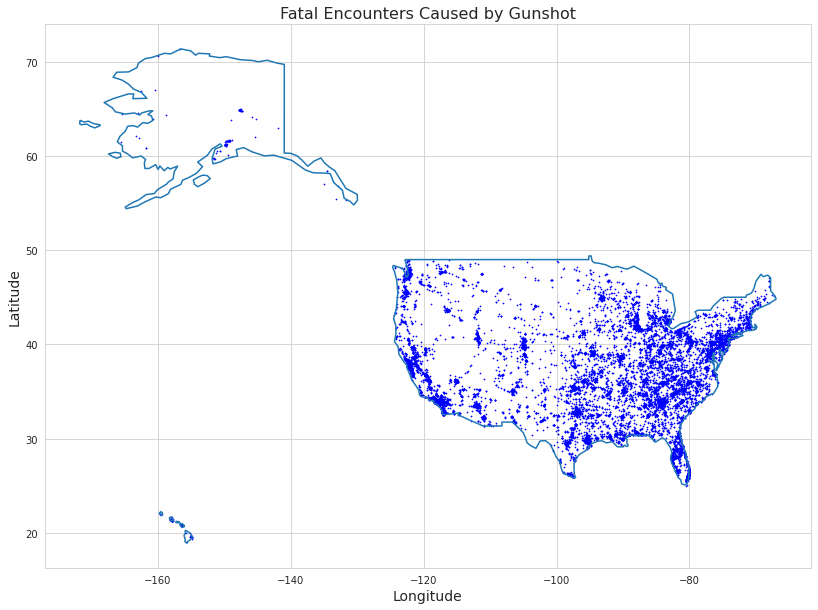

In [ ]:
Gun = df[df['Cause'] == 'Gunshot']
gdf_us = gpd.GeoDataFrame(Gun, geometry=gpd.points_from_xy(Gun.Longitude, Gun.Latitude))
gdf_us = gdf_us.set_crs("EPSG:4326") #Used by google maps, which was used to locate the deaths in the original data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs('EPSG:4326')#convert map to correct crs to match data
usa = world.query('name == "United States of America"') #just US portion of world map
ax = usa.boundary.plot(figsize=(20,10))
gdf_us.plot(ax=ax, markersize=0.5 ,color='blue', figsize=(19,5))
USMap=plt.plot(figsize=(10,20))
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.title('Fatal Encounters Caused by Gunshot', fontsize=16)
plt.show()
from google.colab import files
plt.savefig('USMap.png')
files.download("USMap.png") 

### The highest number of these deaths occur in California, followed by Texas, then Florida and Georgia.

In [ ]:
Gun.Death_loc_st.value_counts()[:4]

CA    3309
TX    1765
FL    1304
GA     753
Name: Death_loc_st, dtype: int64

#<font color='teal'> Locations of fatal encounters by gunshot in California </font>
In California, the highest density of deaths occurs near Los Angelos.

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

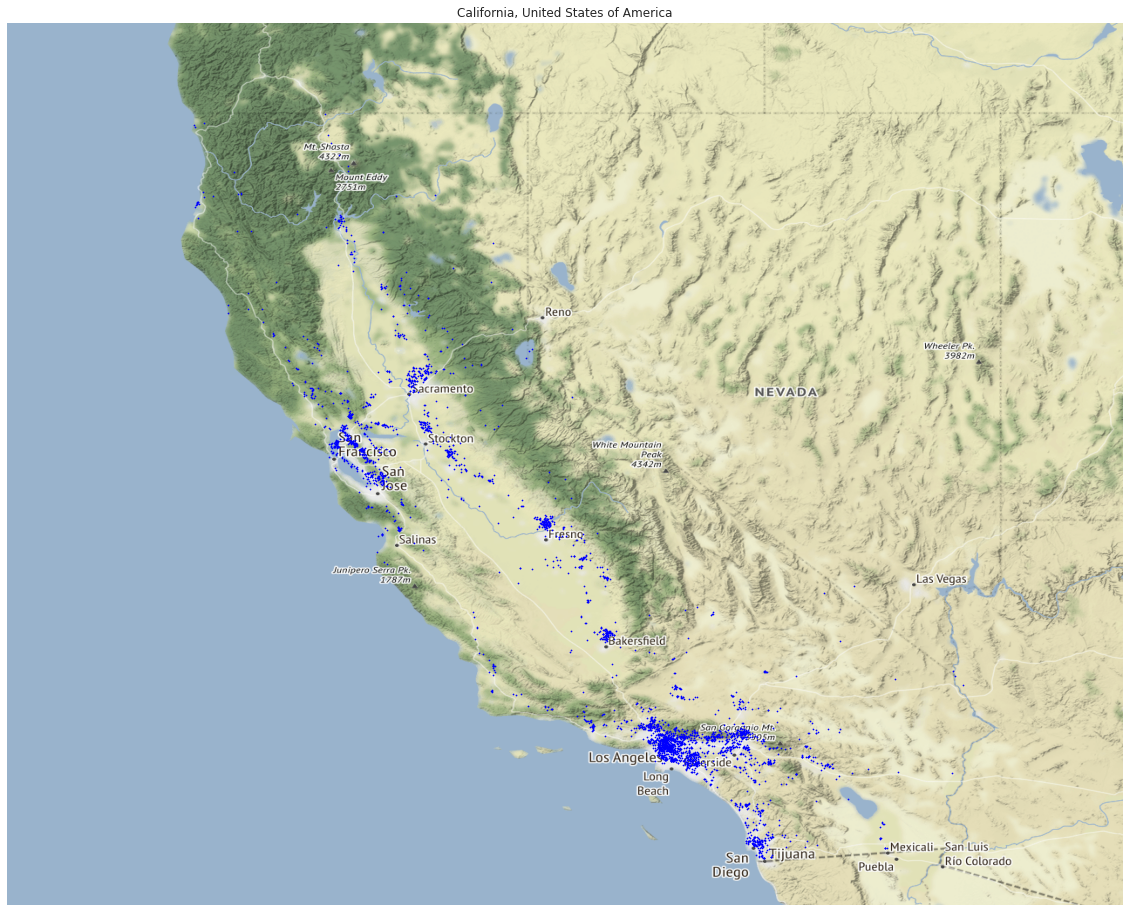

In [ ]:
CA = Gun[Gun.Death_loc_st=='CA']
Lat = CA.Latitude
Long = CA.Longitude
CA.Latitude = Lat
CA.Longitude = Long
gdf = gpd.GeoDataFrame(CA, geometry=gpd.points_from_xy(CA.Longitude, CA.Latitude))
gdf = gdf.set_crs("EPSG:4326")
fig, ax = plt.subplots(figsize=(20, 20))
loc = ctx.Place("California", zoom_adjust=0)  # zoom_adjust modifies the auto-zoom
gdf.plot(ax=ax, markersize=0.5 ,color='blue')
ctx.plot_map(loc,ax=ax)
from google.colab import files
plt.savefig('CAMap.png')
files.download("CAMap.png") 

#<font color='teal'> Locations of fatal encounters by gunshot in Texas </font>
In Texas, the highest density of deaths occurs near major cities.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

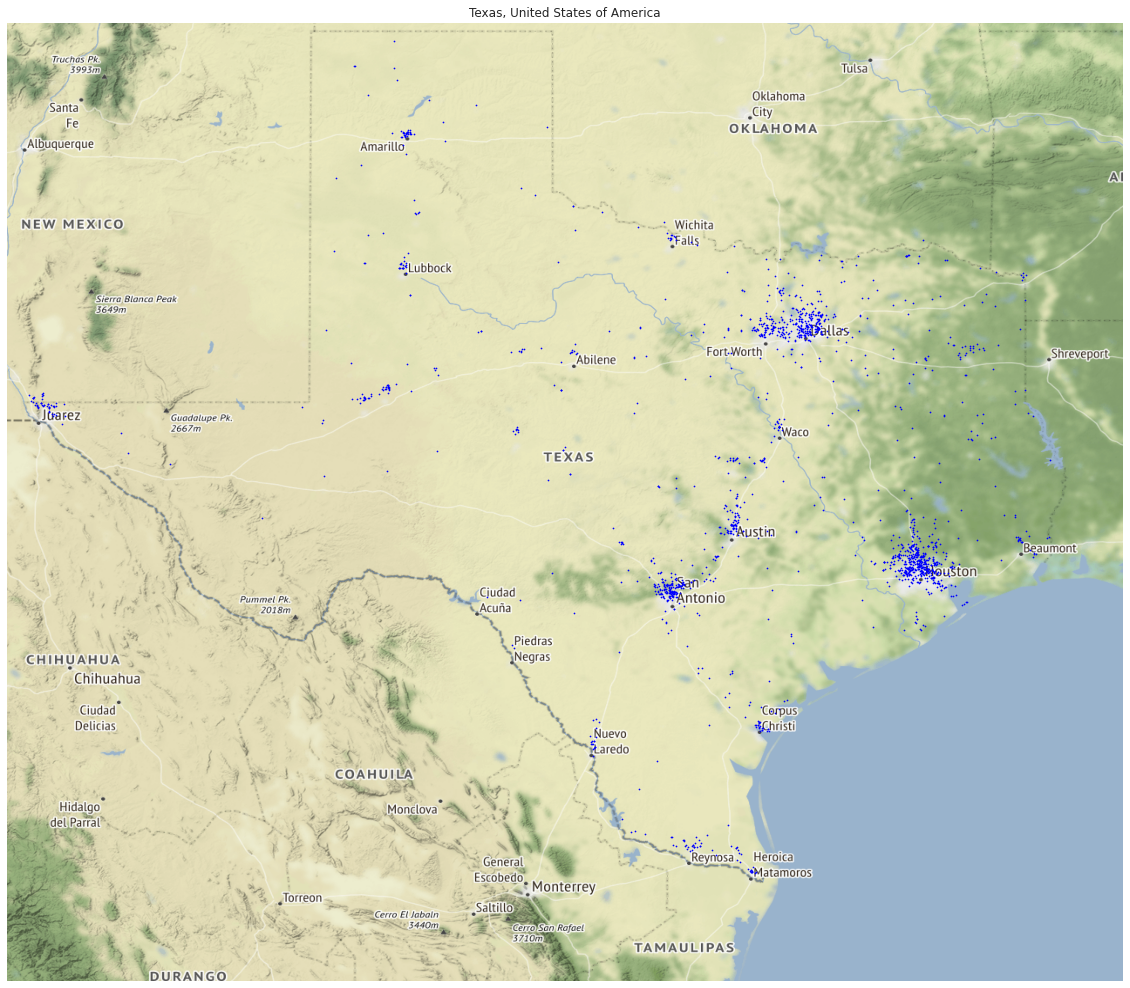

In [ ]:
TX = Gun[Gun.Death_loc_st=='TX']
#Manual fixes to erroneous lat longs
Lat = TX.Latitude
Long = TX.Longitude
Lat.iloc[1138] = 29.4841368
Lat.iloc[1140] = 32.8068085
Long.iloc[1138] = -95.1562599
Long.iloc[1140] = -96.6788695
TX.Latitude = Lat
TX.Longitude = Long
gdf = gpd.GeoDataFrame(TX, geometry=gpd.points_from_xy(TX.Longitude, TX.Latitude))
gdf = gdf.set_crs("EPSG:4326")
fig, ax = plt.subplots(figsize=(20, 20))
loc = ctx.Place("Texas", zoom_adjust=0)
gdf.plot(ax=ax, markersize=0.5 ,color='blue')
ctx.plot_map(loc,ax=ax)
from google.colab import files
plt.savefig('TXMap.png')
files.download("TXMap.png") 

#<font color='teal'> Timeline of Fatal Encounters nationwide </font>
The number of fatal encounters has increased nearly linearly from 2000 through 2019, with deaths caused by gunshot being the leading factor.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

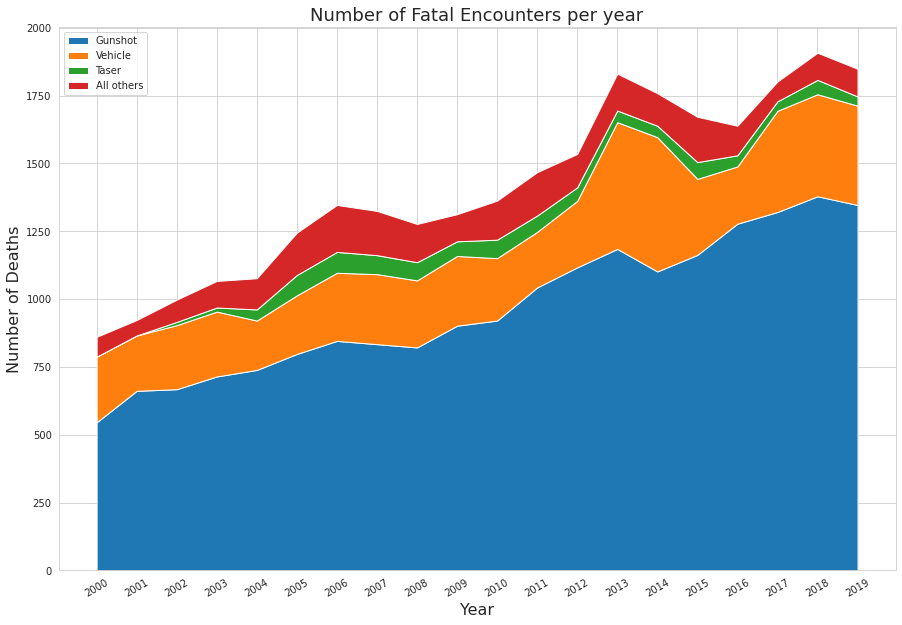

In [ ]:
Years = pd.to_datetime(df.Year)
Years_unique=df.Year.unique()[:20] #exclude 2020 because it's an incomplete year as of september
Yearlist=[]
Gunlist=[]
Vehiclelist=[]
Taserlist=[]
Otherlist=[]
for i in Years_unique:
  Year_sum=np.sum((df.Year==i)==True)
  Yearlist.append(Year_sum)
  Gunlist.append(df.loc[(df['Year'] == i) & (df['Cause'] == 'Gunshot'), 'Cause'].count())
  Vehiclelist.append(df.loc[(df['Year'] == i) & (df['Cause'] == 'Vehicle'), 'Cause'].count())
  Taserlist.append(df.loc[(df['Year'] == i) & (df['Cause'] == 'Tasered'), 'Cause'].count())
  Otherlist.append(df.loc[(df['Year'] == i) & (df['Cause'] != 'Gunshot') & (df['Cause'] != 'Vehicle') & (df['Cause'] != 'Taser'), 'Cause'].count())
fig, ax = plt.subplots(figsize=(15,10))
sns.set_style("whitegrid")
plt.stackplot(Years_unique, Gunlist, Vehiclelist, Taserlist, Otherlist, labels=['Gunshot','Vehicle','Taser','All others'])
plt.xticks(range(2000,2020))
plt.ylabel('Number of Deaths', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title('Number of Fatal Encounters per year', fontsize=18)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
plt.legend(loc='upper left')
from google.colab import files
plt.savefig("YearByCause.png")
files.download("YearByCause.png") 

#<font color='teal'> Agencies responsible for the highest number of Fatal Encounters nationwide </font>
The top agencies responsible for the most deaths in the US are associated with some, but not all of the largest cities with two of the top five in Los Angelos, CA.

In [ ]:
df['Resp_Ag'].value_counts()[:5]

Los Angeles Police Department              469
Chicago Police Department                  430
Los Angeles County Sheriff's Department    350
City of New York Police Department         327
Houston Police Department                  314
Name: Resp_Ag, dtype: int64

However these agencies are not responsible for the linear increase in gun-related fatal encounters from 2000-2019:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

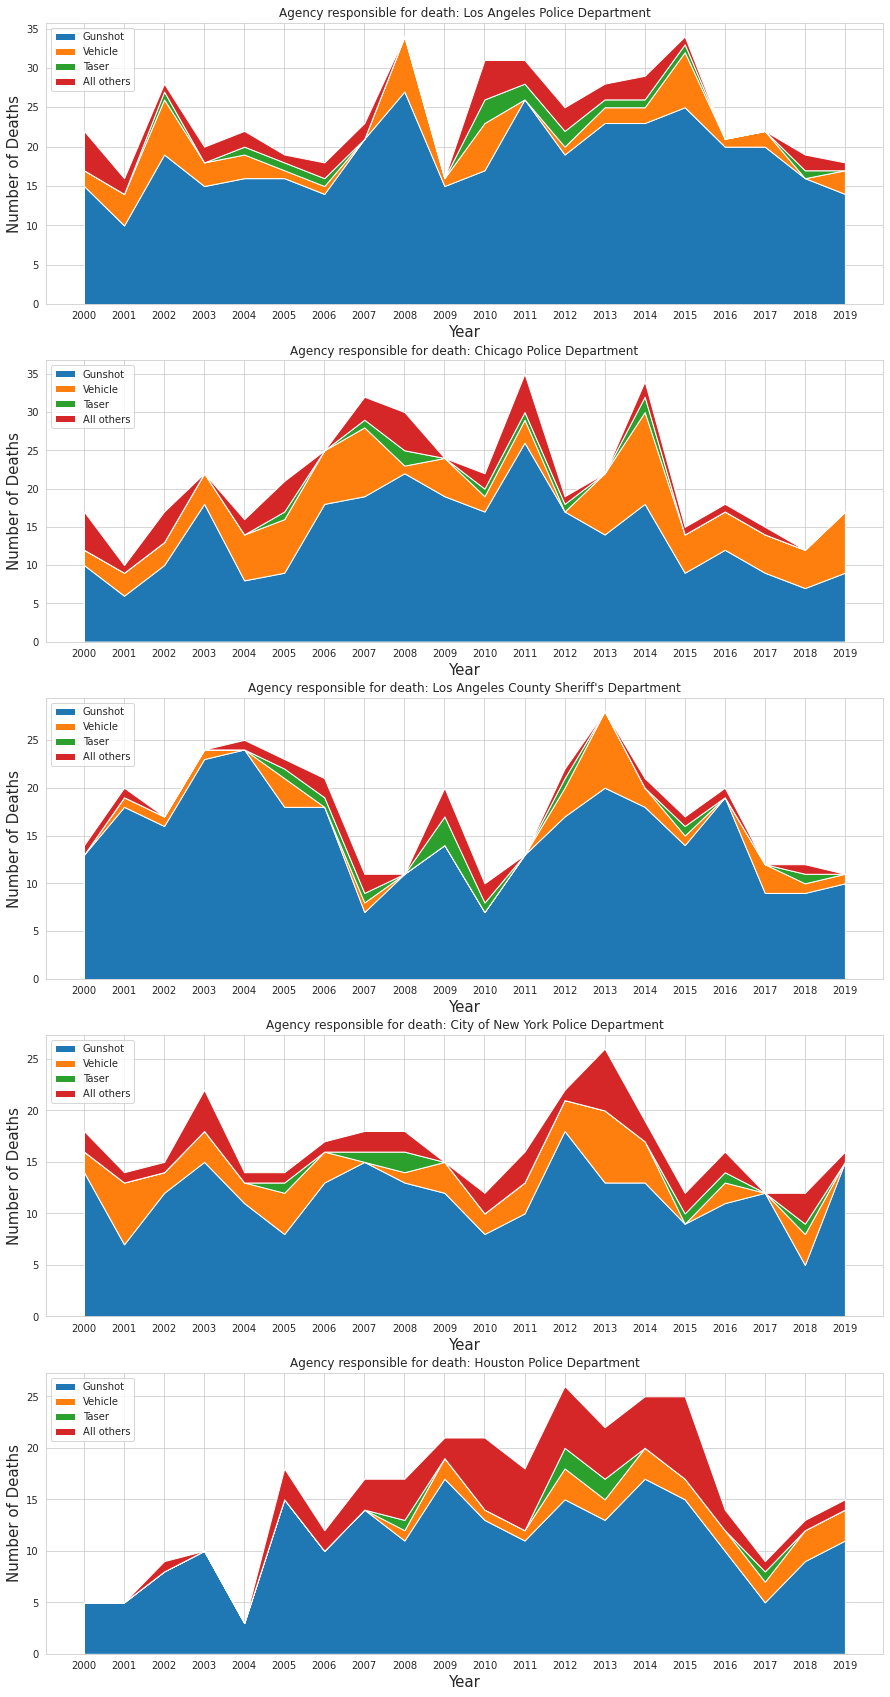

In [ ]:
dfLAPD = df.loc[(df['Resp_Ag'] == 'Los Angeles Police Department')] #Create a df for just LAPD
dfCHID = df.loc[(df['Resp_Ag'] == 'Chicago Police Department')] #Create a df for just CHID
dfLASD = df.loc[(df['Resp_Ag'] == 'Los Angeles County Sheriff\'s Department')] #Create a df for just LASD
dfNYPD = df.loc[(df['Resp_Ag'] == 'City of New York Police Department')] #Create a df for just NYPD
dfHPD = df.loc[(df['Resp_Ag'] == 'Houston Police Department')] #Create a df for just HPD
RESP = ('LAPD','CHID','LASD','NYPD','HPD') #list of police departments
RESP_long = ('Los Angeles Police Department','Chicago Police Department','Los Angeles County Sheriff\'s Department','City of New York Police Department','Houston Police Department')
Years = pd.to_datetime(df.Year)
Years_unique=df.Year.unique()[:20] #exclude 2020 because it's an incomplete year as of september
###Initialize lists
Yearlist = []
Guns= [[] for _ in range(5)]
Veh= [[] for _ in range(5)]
Tas= [[] for _ in range(5)]
Oth= [[] for _ in range(5)]

for i in Years_unique:
  Year_sum=np.sum((df.Year==i)==True)
  Yearlist.append(Year_sum)
for i in range(0,5):
  for j in Years_unique:
    Guns[i].append(df.loc[(df['Year'] == j) & (df['Resp_Ag'] == RESP_long[i]) & (df['Cause'] == 'Gunshot'), 'Cause'].count())
    Veh[i].append(df.loc[(df['Year'] == j) & (df['Resp_Ag'] == RESP_long[i]) & (df['Cause'] == 'Vehicle'), 'Cause'].count())
    Tas[i].append(df.loc[(df['Year'] == j) & (df['Resp_Ag'] == RESP_long[i]) & (df['Cause'] == 'Tasered'), 'Cause'].count())
    Oth[i].append(df.loc[(df['Year'] == j) & (df['Resp_Ag'] == RESP_long[i]) & (df['Cause'] != 'Gunshot') & (df['Cause'] != 'Vehicle') & (df['Cause'] != 'Taser'), 'Cause'].count())

fig, axs = plt.subplots(5,figsize=(15,30))
sns.set_style("whitegrid")
for k in range(0,5):
  axs[k].stackplot(Years_unique, Guns[k], Veh[k], Tas[k], Oth[k], labels=['Gunshot','Vehicle','Taser','All others'])
  axs[k].title.set_text('Agency responsible for death: ' + str(RESP_long[k]))
  axs[k].set_ylabel('Number of Deaths', fontsize=15)
  axs[k].set_xlabel('Year', fontsize=15)
  axs[k].legend(loc="upper left")
plt.setp(axs, xticks=range(2000,2020))
from google.colab import files
plt.savefig("YearByCauseByAgency.png")
files.download("YearByCauseByAgency.png") 

#<font color='teal'> Timeline of Fatal Encounters nationwide in 2020 </font>
It is not clear if the recent attention towards the deaths of unarmed Black individuals has impacted the number of fatal gun encounters.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

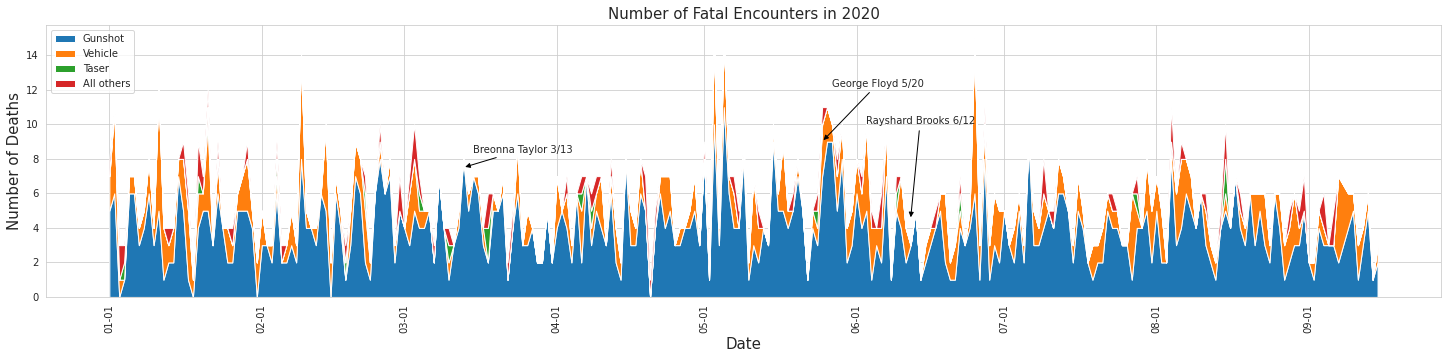

In [ ]:

df2020 = df.loc[(df['Year'] == 2020)] #Create a df for just 2020
dates=df2020.Injury_date.unique()
datelist=[]
Gunlist=[]
Vehiclelist=[]
Taserlist=[]
Otherlist=[]
for i in dates:
  date_sum=np.sum((df.Injury_date==i)==True)
  datelist.append(date_sum)
  Gunlist.append(df.loc[(df['Injury_date'] == i) & (df['Cause'] == 'Gunshot'), 'Cause'].count())
  Vehiclelist.append(df.loc[(df['Injury_date'] == i) & (df['Cause'] == 'Vehicle'), 'Cause'].count())
  Taserlist.append(df.loc[(df['Injury_date'] == i) & (df['Cause'] == 'Tasered'), 'Cause'].count())
  Otherlist.append(df.loc[(df['Injury_date'] == i) & (df['Cause'] != 'Gunshot') & (df['Cause'] != 'Vehicle') & (df['Cause'] != 'Taser'), 'Cause'].count())
  dates = pd.to_datetime(dates, infer_datetime_format=True)
fig, ax = plt.subplots(figsize=(25,5))
sns.set_style("whitegrid")
plt.stackplot(dates, Gunlist, Vehiclelist, Taserlist, Otherlist, labels=['Gunshot','Vehicle','Taser','All others'])
plt.ylabel('Number of Deaths', fontsize=15)
ax.xaxis_date()
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
plt.xlabel('Date', fontsize=15)
plt.title('Number of Fatal Encounters in 2020', fontsize=15)
ax.xaxis.set_tick_params(rotation=90, labelsize=10)
plt.legend(loc='upper left')
ax.get_xlim()
ax.annotate("George Floyd 5/20",
            xy=(mdates.date2num(dt.datetime(2020, 5, 25)),9), xytext=(10, 55), 
            textcoords='offset points', arrowprops={'arrowstyle':'-|>', 'color':'black'}
            )
ax.annotate("Breonna Taylor 3/13",
            xy=(mdates.date2num(dt.datetime(2020, 3, 13)),7.5), xytext=(10, 15), 
            textcoords='offset points', arrowprops={'arrowstyle':'-|>', 'color':'black'}
            )
ax.annotate("Rayshard Brooks 6/12",
            xy=(mdates.date2num(dt.datetime(2020, 6, 12)),4.5), xytext=(-45, 95), 
            textcoords='offset points', arrowprops={'arrowstyle':'-|>', 'color':'black'}
            )
from google.colab import files
plt.savefig("2020ByCause.png")
files.download("2020ByCause.png") 

#<font color='teal'> Additional Questions Remain </font>
Modeling is needed to determine where the national uptick is coming from and to identify features that correlate well with them. 